# Verification

For verification, we will test our models on comments from the month of November 2015. In a similar manner as we scraped, we will take top-level comments from the top reddit threads of that month and predict scores.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import time
from bs4 import BeautifulSoup
import urllib2
import re
import praw
import cPickle

In [1]:
mmddyy_range = ('11-01-2015', '11-30-2015')
f_epoch = lambda x: int(time.mktime(time.strptime(x, '%m-%d-%Y')))
time_range = str(f_epoch(mmddyy_range[0])) + '..' + str(f_epoch(mmddyy_range[1]))
print time_range

1446350400..1448859600


We will thus scrape from the URL https://www.reddit.com/r/AskReddit/search?sort=top&q=timestamp%3A1446350400..1448859600&restrict_sr=on&syntax=cloudsearch, where we sort by "top" this time instead of "comments" -- we want threads that have been voted extensively upon. The result should be the top-level comments scraped from the highest-voted twenty-five threads.

In [2]:
url = 'https://www.reddit.com/r/AskReddit/search?sort=top&q=timestamp%3A1446350400..1448859600&restrict_sr=on&syntax=cloudsearch'

In [3]:
data = BeautifulSoup(urllib2.urlopen(url).read(), 'html.parser')

In [4]:
rows = data.findAll("a", attrs = {'class': 'search-comments may-blank'}, limit=None)
url_list = [str(r.attrs['href'])[:-17] + '.json' for r in rows]

thread_ids = []
for elt in url_list:
    time.sleep(30)
    json_text = urllib2.urlopen(elt).read()
    thread_ids.append(re.search(r'\"id\": \"([a-zA-Z0-9_]+)\"', json_text).group(1))

['3tdwy2', '3ucqxj', '3regbo', '3r2siv', '3secjr', '3ta5bz', '3si0bb', '3t1q82', '3tfpe2', '3ruhnj', '3r76bx', '3so18a', '3rbzln', '3tkemy', '3rih54', '3u2szy', '3u76qe', '3su6er', '3tid38', '3tqjr6', '3ur7jx', '3rg1rf', '3ualrk', '3ss8oz', '3rmbnh']


In [5]:
r = praw.Reddit('Getting comments for CS109 Final Project')

thread_d = {}
for t_id in thread_ids:
    time.sleep(10)
    submission = r.get_submission(submission_id=t_id)
    submission.replace_more_comments(limit=100, threshold=0)
    all_comments = submission.comments
    thread_d[t_id] = all_comments

In [6]:
print len(thread_d)

25


In [8]:
print sum([len(comments) for thread, comments in thread_d.items()])

36787


In [10]:
cPickle.dump(thread_d, open('v_comments_dict.p', 'wb')) 
thread_d_load = cPickle.load(open('v_comments_dict.p', 'rb'))
print len(thread_d_load)
print sum([len(comments) for thread, comments in thread_d_load.items()])

25
36787


Repeating the feature selection process:

In [ ]:
fields = ['_replies',
          '_submission',
          'author',
          'author_flair_css_class',
          'author_flair_text',
          'banned_by',
          'body',
          'body_html',
          'controversiality',
          'created',
          'created_utc',
          'distinguished',
          'downs',
          'edited',
          'gilded',
          'score',
          'score_hidden',
          'subreddit',
          'ups'
         ]

dlist = []
for thread in thread_d_load: 
    for comment in thread_d_load[thread]:
        temp_d = {}
        temp_d['thread'] = thread
        for field in fields:
            temp_d[field] = comment.__dict__[field]
        dlist.append(temp_d)

In [12]:
df = pd.DataFrame(dlist)

In [13]:
df.head()

,_replies,_submission,author,author_flair_css_class,author_flair_text,banned_by,body,body_html,controversiality,created,created_utc,distinguished,downs,edited,gilded,score,score_hidden,subreddit,thread,ups
0,[That guy is more confused than a toddler at a...,5809 :: What is an analogy that gets your poin...,implementor,None,None,None,"One I heard from my grandfather, about a kid t...","<div class=""md""><p>One I heard from my grandfa...",0,1447359044,1447330244,None,0,False,0,2504,False,AskReddit,3si0bb,2504
1,"[Oooh, I'm stealing this one for the people t...",5809 :: What is an analogy that gets your poin...,PuxinF,None,None,None,Motorcycles are like butt plugs. It doesn't m...,"<div class=""md""><p>Motorcycles are like butt p...",0,1447347016,1447318216,None,0,False,0,3278,False,AskReddit,3si0bb,3278
2,"[Huh, this actually seems the most relevant an...",5809 :: What is an analogy that gets your poin...,FlyingGerbel,None,None,None,My boss was once describing the size of a smal...,"<div class=""md""><p>My boss was once describing...",0,1447346788,1447317988,None,0,False,0,6277,False,AskReddit,3si0bb,6277
3,[I've heard them referred to as mumble pants -...,5809 :: What is an analogy that gets your poin...,Toady_,None,None,None,"My mom, while talking about one of my sisters'...","<div class=""md""><p>My mom, while talking about...",0,1447344342,1447315542,None,0,False,0,3976,False,AskReddit,3si0bb,3976
4,[Placeholder post until I can come up with a q...,5809 :: What is an analogy that gets your poin...,shidonichan,None,None,None,"maybe not *wildly* inappropriate, but:\n\ni've...","<div class=""md""><p>maybe not <em>wildly</em> i...",0,1447341519,1447312719,None,0,False,0,2915,False,AskReddit,3si0bb,2915


In [15]:
df['character_count'] = df['body'].map(lambda x : len(x))

In [16]:
df['time_delay'] = df.apply(lambda row : row['created_utc'] - row['_submission'].created_utc, axis=1)

In [17]:
def word_count(text):
    wordList = re.sub("[^\w]", " ",  text).split()
    return len(wordList)

df['word_count'] = df['body'].map(lambda x : word_count(x))

In [18]:
import csv

input_file = csv.DictReader(open("profanity.csv"))

SWEARS = []
for row in input_file:
    SWEARS.append(row["swears"])

def swear_count(text):
    count = 0
    for swear in SWEARS:
        if swear in text:
            count = count + 1
    return count

df['swear_count'] = df['body'].map(lambda x : swear_count(x))

In [19]:
def word_size(text):
    words = re.sub("[^\w]", " ",  text).split()
    if len(words) > 0: 
        avg = sum(len(word) for word in words)/len(words)
    else:
        return 0
    return avg

df['word_size'] = df['body'].map(lambda x : word_size(x))

In [20]:
def link_count(html):
    urls = re.findall('<a href="?\'?([^"\'>]*)', html)
    count = len(urls)
    return count

df['link_count'] = df['body_html'].map(lambda x : link_count(x))

In [21]:
def italics_count(html):
    italics = re.findall('<em>', html)
    count = len(italics)
    return count

df['italics_count'] = df['body_html'].map(lambda x : italics_count(x))

In [22]:
def bold_count(html):
    bold = re.findall('<strong>', html)
    count = len(bold)
    return count

df['bold_count'] = df['body_html'].map(lambda x : bold_count(x))

In [23]:
def st_count(html):
    st = re.findall('<s>', html)
    count = len(st)
    return count

df['strikethrough_count'] = df['body_html'].map(lambda x : st_count(x))

In [24]:
def bq_count(html):
    bq = re.findall('<blockquote>', html)
    count = len(bq)
    return count

df['blockquote_count'] = df['body_html'].map(lambda x : bq_count(x))

In [25]:
def p_count(html):
    ps = re.findall('<p>', html)
    count = len(ps)
    return count

df['paragraph_count'] = df['body_html'].map(lambda x : p_count(x))

In [38]:
import string
titles_orig = list(set([str(x.title.replace(u"\u2019", u"\'")) for x in df._submission]))
titles = [x.translate(None, string.punctuation).lower() for x in titles_orig]
question_words = ['who', 'whos', 'whose', 'what', 'whats', 'where', 'wheres', 'when', 'whens', 'why', 'how', 'hows']
trivial_words = ['that', 'have', 'been', 'should', 'your', 'youre', 'were', 'with', 'does',
                 'youve', 'about', 'wasnt', 'dont', 'just', 'from', 'this', 'could']

titles_list = [x.split() for x in titles]

# remove length 1, 2, and 3 words, and words from question_words and trivial_words
filtered_titles = [[x for x in elt if len(x) > 3 and x not in question_words and x not in trivial_words] for elt in titles_list]

import nltk
from nltk.corpus import wordnet

synonyms_d = {}

for i in range(len(titles_orig)):
    synonyms = []
    for word in filtered_titles[i]:
        for ss in wordnet.synsets(word):
            syn_list_spaces = [str(x).replace('_', ' ') for x in ss.lemma_names()]
            synonyms += syn_list_spaces
    synonyms_d[titles_orig[i]] = set(synonyms)

syn_number = []
syn_proportion = []

for index, row in df.iterrows():
    synonyms = synonyms_d[str(row._submission.title.replace(u"\u2019", u"\'"))]
    comment_list = [x.encode("utf-8") for x in row.body.split()]
    if len(comment_list) == 0:
        syn_number.append(0)
        syn_proportion.append(0.)
        continue
    count = sum([1 for word in comment_list if word in synonyms])
    syn_number.append(count)
    syn_proportion.append(float(count)/float(len(comment_list)))

df['syn_count'] = syn_number
df['syn_perc'] = syn_proportion

In [39]:
df['un_length'] = df['author'].map(lambda x : len(str(x)))

In [40]:
def un_punc (text):
    total = 0
    if '_' in text: total += 1
    if '-' in text: total += 1
    return total

df['un_punc'] = df['author'].map(lambda x : un_punc(str(x)))

In [41]:
def un_case (text):
    if text.islower(): return 0
    if text.isupper(): return 1
    return 2

df['un_case'] = df['author'].map(lambda x : un_case(str(x)))

In [42]:
def un_number (text):    
    numbers = sum(c.isdigit() for c in text)
    return float(numbers)/float(len(text))

df['un_number'] = df['author'].map(lambda x : un_number(str(x)))

In [43]:
df['un_PM'] = df['author'].map(lambda x : 1 if str(x)[:3] == "PM_" else 0)
df['un_bot'] = df['author'].map(lambda x : 1 if 'bot' in str(x).lower() else 0)

In [44]:
df['i_author_flair_css_class']=(df.author_flair_css_class.notnull())*1
del df['author_flair_css_class']
df['i_author_flair_text']=(df.author_flair_text.notnull())*1
del df['author_flair_text']
df['i_distinguished']=(df.distinguished.notnull())*1
del df['distinguished']
df['i_edited']=(df.edited)*1
del df['edited']
df['i_score_hidden']=(df.score_hidden)*1
del df['score_hidden']
df['i_banned_by']=(df.banned_by.notnull())*1
del df['banned_by']

In [45]:
df.head()

,_replies,_submission,author,body,body_html,controversiality,created,created_utc,downs,gilded,...,un_case,un_number,un_PM,un_bot,i_author_flair_css_class,i_author_flair_text,i_distinguished,i_edited,i_score_hidden,i_banned_by
0,[That guy is more confused than a toddler at a...,5809 :: What is an analogy that gets your poin...,implementor,"One I heard from my grandfather, about a kid t...","<div class=""md""><p>One I heard from my grandfa...",0,1447359044,1447330244,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[Oooh, I'm stealing this one for the people t...",5809 :: What is an analogy that gets your poin...,PuxinF,Motorcycles are like butt plugs. It doesn't m...,"<div class=""md""><p>Motorcycles are like butt p...",0,1447347016,1447318216,0,0,...,2,0,0,0,0,0,0,0,0,0
2,"[Huh, this actually seems the most relevant an...",5809 :: What is an analogy that gets your poin...,FlyingGerbel,My boss was once describing the size of a smal...,"<div class=""md""><p>My boss was once describing...",0,1447346788,1447317988,0,0,...,2,0,0,0,0,0,0,0,0,0
3,[I've heard them referred to as mumble pants -...,5809 :: What is an analogy that gets your poin...,Toady_,"My mom, while talking about one of my sisters'...","<div class=""md""><p>My mom, while talking about...",0,1447344342,1447315542,0,0,...,2,0,0,0,0,0,0,0,0,0
4,[Placeholder post until I can come up with a q...,5809 :: What is an analogy that gets your poin...,shidonichan,"maybe not *wildly* inappropriate, but:\n\ni've...","<div class=""md""><p>maybe not <em>wildly</em> i...",0,1447341519,1447312719,0,0,...,0,0,0,0,0,0,0,0,0,0


Pickling our work:

In [3]:
#cPickle.dump(df, open('df_v_features.p', 'wb'))
df_test = cPickle.load(open('df_v_features.p', 'rb'))
df_test.head()

,_replies,_submission,author,body,body_html,controversiality,created,created_utc,downs,gilded,score,subreddit,thread,ups,character_count,time_delay,word_count,swear_count,word_size,link_count,italics_count,bold_count,strikethrough_count,blockquote_count,paragraph_count,syn_count,syn_perc,un_length,un_punc,un_case,un_number,un_PM,un_bot,i_author_flair_css_class,i_author_flair_text,i_distinguished,i_edited,i_score_hidden,i_banned_by
0,[That guy is more confused than a toddler at a...,5809 :: What is an analogy that gets your poin...,implementor,"One I heard from my grandfather, about a kid t...","<div class=""md""><p>One I heard from my grandfa...",0,1447359044,1447330244,0,0,2504,AskReddit,3si0bb,2504,132,26838,28,3,3,0,0,0,0,0,1,2,0.076923,11,0,0,0,0,0,0,0,0,0,0,0
1,"[Oooh, I'm stealing this one for the people t...",5809 :: What is an analogy that gets your poin...,PuxinF,Motorcycles are like butt plugs. It doesn't m...,"<div class=""md""><p>Motorcycles are like butt p...",0,1447347016,1447318216,0,0,3278,AskReddit,3si0bb,3278,118,14810,22,1,4,0,1,0,0,0,1,1,0.047619,6,0,2,0,0,0,0,0,0,0,0,0
2,"[Huh, this actually seems the most relevant an...",5809 :: What is an analogy that gets your poin...,FlyingGerbel,My boss was once describing the size of a smal...,"<div class=""md""><p>My boss was once describing...",0,1447346788,1447317988,0,0,6277,AskReddit,3si0bb,6277,313,14582,61,0,3,0,0,0,0,0,3,1,0.016667,12,0,2,0,0,0,0,0,0,0,0,0
3,[I've heard them referred to as mumble pants -...,5809 :: What is an analogy that gets your poin...,Toady_,"My mom, while talking about one of my sisters'...","<div class=""md""><p>My mom, while talking about...",0,1447344342,1447315542,0,0,3976,AskReddit,3si0bb,3976,114,12136,22,0,3,0,0,0,0,0,1,0,0.000000,6,1,2,0,0,0,0,0,0,0,0,0
4,[Placeholder post until I can come up with a q...,5809 :: What is an analogy that gets your poin...,shidonichan,"maybe not *wildly* inappropriate, but:\n\ni've...","<div class=""md""><p>maybe not <em>wildly</em> i...",0,1447341519,1447312719,0,0,2915,AskReddit,3si0bb,2915,295,9313,54,1,4,0,2,0,0,0,2,2,0.039216,11,0,0,0,0,0,0,0,0,0,0,0


And now we can test out our models.

In [4]:
trees = cPickle.load(open('clftree.p', 'rb'))

In [6]:
forest = cPickle.load(open('clfforest.p', 'rb'))

In [9]:
knn = cPickle.load(open('clfkn.p', 'r'))

In [10]:
cols = ['created_utc',
        'time_delay',
        'word_count',
        'character_count',
        'swear_count',
        'word_size',
        'link_count',
        'italics_count',
        'bold_count',
        'strikethrough_count',
        'blockquote_count',
        'paragraph_count',
        'syn_count',
        'syn_perc',
        'un_length',
        'un_punc',
        'un_case',
        'un_number',
        'un_PM',
        'un_bot'
        ]

In [11]:
decision_tree_predictions = trees.predict(df_test[cols])
random_forest_predictions = forest.predict(df_test[cols])
knn_predictions = knn.predict(df_test[cols])

print "Decision Tree MAE:", np.mean(abs(np.exp(decision_tree_predictions) - df_test.ups))
print "Random forest MAE:", np.mean(abs(np.exp(random_forest_predictions) - df_test.ups))
print "k-Nearest MAE:", np.mean(abs(np.exp(knn_predictions) - df_test.ups))
print "Median MAE:", np.mean(abs(2 - df_test.ups))
print "Mode MAE:", np.mean(abs(1 - df_test.ups))
print "Mean MAE:", np.mean(abs(79.3385934016 - df_test.ups))

Decision Tree MAE: 78.4599933875
Random forest MAE: 79.3170001888
k-Nearest MAE: 81.3909830991
Median MAE: 78.00347949
Mode MAE: 78.5517438225
Mean MAE: 145.088082883


Not too good -- the random forest and k-Nearest Neighbor predictors do slightly worse than our baseline median/mode predictors, and the decision tree predictor does worse than the median. Let's see if we can visualize what's going on -- that is, what our predictions look like compared to what the actual scores look like.

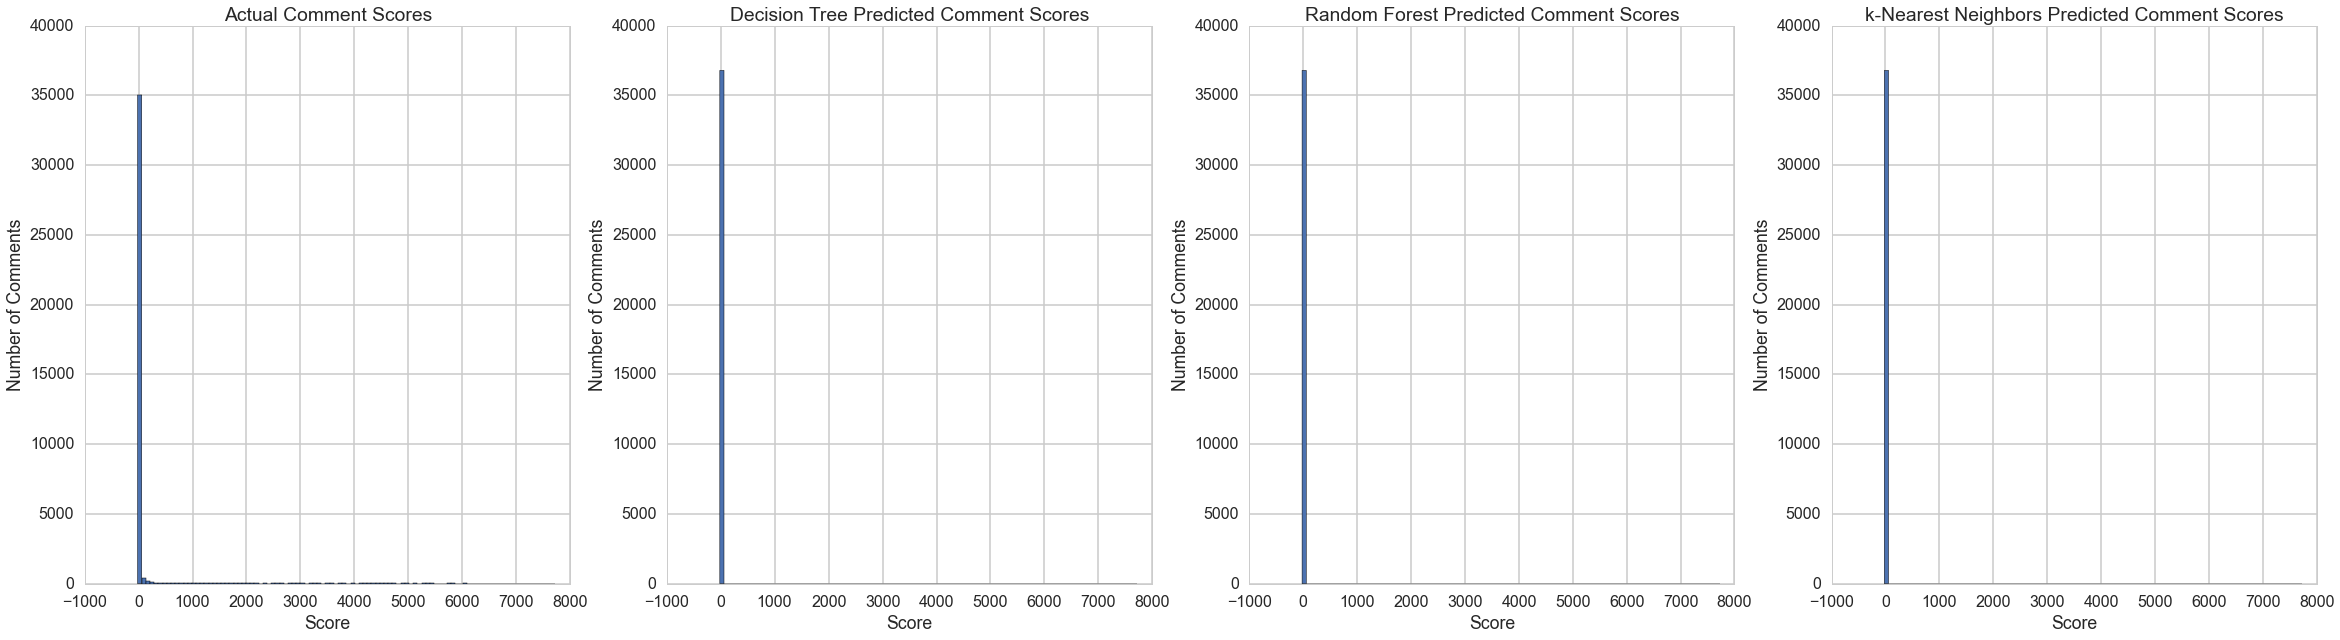

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(40,10))

bins = axes[0].hist(df_test.ups,100)[1]
axes[0].set_title("Actual Comment Scores")
axes[1].hist(decision_tree_predictions, bins)
axes[1].set_title("Decision Tree Predicted Comment Scores")
axes[2].hist(random_forest_predictions, bins)
axes[2].set_title("Random Forest Predicted Comment Scores")
axes[3].hist(knn_predictions, bins)
axes[3].set_title("k-Nearest Neighbors Predicted Comment Scores")

for ax in axes:
    ax.set_xlabel("Score")
    ax.set_ylabel("Number of Comments")

In other words, our models are assigning scores near 1 to pretty much all comments. This is reflected in their performance being near that of the median and mode predictors, but it also shows that they are unable to glean the essence of what makes a post able to score high.